<a href="https://colab.research.google.com/github/LeoFernanndes/notebooks/blob/master/titanic_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic Kaggle

## Standard Classifier

In [0]:
import pandas as pd


url = 'https://raw.githubusercontent.com/LeoFernanndes/datasets/master/titanic_%20train.csv' 
titanic_df = pd.read_csv(url)

columns_order = ['PassengerId', 'Name', 'Fare', 'Sex', 'Age', 'Pclass', 'SibSp', 'Parch', 'Embarked', 'Cabin', 'Ticket', 'Survived']

titanic = titanic_df.reindex(columns_order, axis= 1)

In [0]:


def value_y(valor):
  if valor < 20:
    return 1
  else:
    return 0

def value_m(valor):
  if (valor >=20 and valor <=50):
    return 1
  else:
    return 0


def value_e(valor):
  if valor > 50:
    return 1
  else:
    return 0

def fare_bin(valor):
  if valor < 7:
    return 1
  elif (valor >= 7 and valor < 14):
    return 2
  elif (valor >= 14 and valor < 31):
    return 3
  else:
    return 4


In [0]:
# filling in the gaps

for column in titanic.columns:
  if titanic[column].dtype != 'object':
      titanic[column].fillna(titanic[column].mean(), inplace= True)
  else:
      titanic[column] = titanic[column].astype('str')
      titanic[column].fillna(titanic[column].mode(), inplace= True)


from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
for column in titanic.columns:
  if titanic[column].dtype == 'object':
    titanic[column] = le.fit_transform(titanic[column])


titanic['Sex_m'] = titanic_df['Sex'].map({'male': 1, 'female': 0})
titanic['Sex_f'] = titanic_df['Sex'].map({'male': 0, 'female': 1})

titanic['Age_y'] = titanic_df['Age'].apply(value_y)
titanic['Age_m'] = titanic_df['Age'].apply(value_m)
titanic['Age_e'] = titanic_df['Age'].apply(value_e)

titanic['Fare'] = titanic_df['Fare'].apply(fare_bin)

colunas_ = ['Fare', 'Sex', 'Age', 'Pclass', 'SibSp', 'Parch', 'Survived']
colunas = ['Fare',  'Sex_m', 'Sex_f', 'Age_y', 'Age_m', 'Age_e', 'Pclass', 'SibSp', 'Parch',
       'Embarked', 'Cabin', 'Ticket']


titanic_train = titanic.iloc[0: 500]
titanic_test = titanic.iloc[500: ]

x_train = titanic_train[colunas]
y_train = titanic_train['Survived']

x_test = titanic_test[colunas]
y_test = titanic_test['Survived']

In [12]:
#titanic[titanic['Age']]
titanic['Age'].describe()

count    891.000000
mean      29.699118
std       13.002015
min        0.420000
25%       22.000000
50%       29.699118
75%       35.000000
max       80.000000
Name: Age, dtype: float64

In [13]:
x_train

,Fare,Sex_m,Sex_f,Age_y,Age_m,Age_e,Pclass,SibSp,Parch,Embarked,Cabin,Ticket
0,2,1,0,0,1,0,3,1,0,2,147,523
1,4,0,1,0,1,0,1,1,0,0,81,596
2,2,0,1,0,1,0,3,0,0,2,147,669
3,4,0,1,0,1,0,1,1,0,2,55,49
4,2,1,0,0,1,0,3,0,0,2,147,472
...,...,...,...,...,...,...,...,...,...,...,...,...
495,3,1,0,0,0,0,3,0,0,0,147,176
496,4,0,1,0,0,1,1,1,0,0,96,454
497,3,1,0,0,0,0,3,0,0,2,147,564
498,4,0,1,0,1,0,1,1,2,2,62,37


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform') 

 0.7672634271099744 0.6994884910485939 0.6666666666666667 0.6064509861155858 




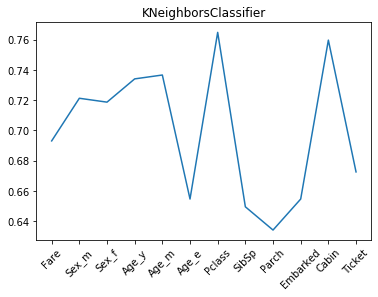

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1) 

 0.7928388746803069 0.7419011082693946 0.7032967032967032 0.6475227234064203 




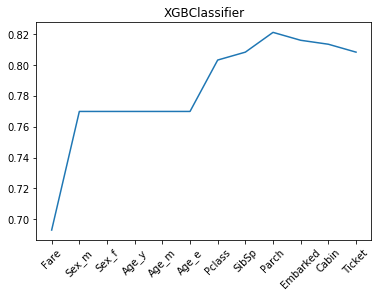

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 

 0.7774936061381074 0.7498579141801662 0.6859205776173285 0.6544788332877323 




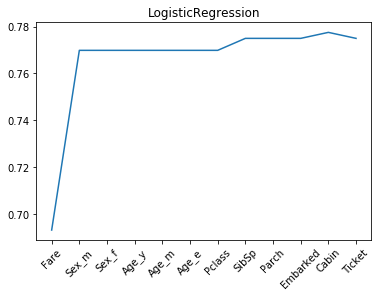

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 

 0.7774936061381074 0.7568094629156005 0.6859205776173285 0.66190781947758 




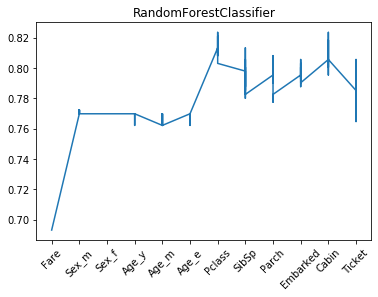

GaussianNB(priors=None, var_smoothing=1e-09) 

 0.7749360613810742 0.7593691389599321 0.6857142857142857 0.6644827067319604 




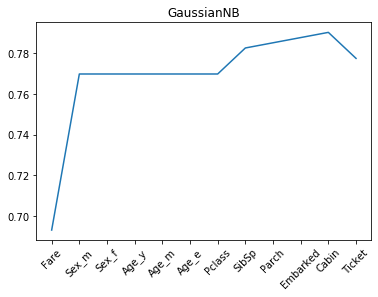

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score, accuracy_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


df_resultados = pd.DataFrame({'PassengerId': titanic_test['PassengerId']})
accuracy_list = [] 
f1_list = []

classifiers = [KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform'),
               
               XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1),

               LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False),

               RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False),

               GaussianNB(priors=None, var_smoothing=1e-09)]



for clf in classifiers:

  x_axis = []
  y_axis = []

  for m in range(len(colunas)):
    n = 10
    for iter in range(n):
      
      
      clf.fit(x_train[colunas[0: m+1]], y_train)
      y_pred = clf.predict(x_test[colunas[0: m+1]])
      
      accuracy = accuracy_score(y_pred, y_test)
      accuracy_list.append(accuracy)

      f1 = f1_score(y_pred, y_test)
      f1_list.append(f1)

      y_axis.append(accuracy)
      x_axis.append(colunas[m])

      dataframe = pd.DataFrame({iter: y_pred}, index= titanic_test.index)

      df_resultados = pd.concat([df_resultados, dataframe], axis= 1)

    df_resultados['Final'] = df_resultados.drop(['PassengerId'], axis= 1).mode(axis= 1)[0]
    df_resultados['Porcentagem'] = df_resultados.drop(['PassengerId'], axis= 1).mean(axis= 1)
    accuracy_serie = pd.Series(accuracy_list).sort_values(ascending= True)
    f1_serie = pd.Series(f1_list).sort_values(ascending= True)


    final_accuracy = accuracy_score(df_resultados['Final'], y_test)
    final_f1 = f1_score(df_resultados['Final'], y_test)


  print(clf, 2*'\n', final_accuracy, accuracy_serie.mean(), final_f1, f1_serie.mean(), 2*'\n')

  plt.plot(x_axis, y_axis)
  plt.xticks(rotation= 45)
  plt.yticks()
  plt.title(str(clf).split('(')[0])
  plt.show()

## Stacking Technique

### Simple stacking classification

In [15]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from xgboost import XGBClassifier
import numpy as np
import warnings

warnings.simplefilter('ignore')

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, x_train, y_train, 
                                              cv=8, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.64 (+/- 0.05) [KNN]
Accuracy: 0.79 (+/- 0.04) [Random Forest]
Accuracy: 0.79 (+/- 0.03) [Naive Bayes]
Accuracy: 0.64 (+/- 0.05) [StackingClassifier]


### Probabilities as meta-features

In [16]:
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3],
                          use_probas=True,
                          average_probas=False,
                          meta_classifier=lr)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, x_train, y_train, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 

          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.65 (+/- 0.02) [KNN]
Accuracy: 0.78 (+/- 0.01) [Random Forest]
Accuracy: 0.78 (+/- 0.01) [Naive Bayes]
Accuracy: 0.65 (+/- 0.01) [StackingClassifier]


## References

Comprehensive data exploration with python

https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

Stacked Regressions to predict House Prices

https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

A study on Regression applied to the Ames dataset

https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

Handling imbalanced datasets in machine learning

https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28

Part II. Model Evaluation: Cross Validation, Bias and Variance Tradeoff and How to Diagnose Overfitting

https://medium.com/@karenovna.ak/part-ii-evaluating-a-predictive-model-cross-validation-and-bias-and-variance-tradeoff-9874b836cd2e

Scatterplots and correlation review

https://www.khanacademy.org/math/statistics-probability/describing-relationships-quantitative-data/introduction-to-scatterplots/a/scatterplots-and-correlation-review

Handling Categorical Data in Python

https://www.datacamp.com/community/tutorials/categorical-data
